# Audio Reconstruction - auto encoders

## Architecture générale : CNN ?

Avant de passer à la régression de paramètres de synthé, on va d'abord entraîner un AE à reconstruire les (mel-spectrogrammes) des sons des presets du DX7.

Choix du AE :
* Encodeur/décodeur à CNN sur spectrogramme (FlowSynth, IRCAM 2019)
    * Encodeur (décodeur idem) : 5 couches de 64 canaux, kernel 7, stride 2, dilation 2
    * WAE, qui d'après (Esling et al. 2020) donne au final les meilleures régressions de paramètres de synthé ?
    * Divers VAE avec flow, qui d'après (Esling et al. 2020) donnent la meilleure reconstruction audio ? (avec metadata....)
        * (https://acids-ircam.github.io/flow_synthesizer/#models-details)
* WaveNet
    * 10 couches de kernel 4, stride 2, dilation 1. Nombre de canaux va de 128-512 à 1024 pour mix final
    * Temporal encoder à convolution sur raw audio
        * Comparer le *baseline CNN encoder* avec le *temporal encoder* sur spectrogrammes ? Même si Google Brain/DeepMind restent sur du CNN classique 
    * Décodeur WaveNet : beaucoup trop lourd
* WaveNet baseline (and temporal) :
![](https://pbs.twimg.com/media/C8spAMCXYAAX6ml.jpg)


## Architecture : fonctions d'activation, BN
* Dans les CNN : tester ReLU vs. LeakyReLU vs. ELU (similaires, mais coût de calcul croissant)
* Dernière couche d'encodeur : aucune activation ni BN. On veut effet récupérer mu et logvar sans distorstion et sans BN
* Dernière couche de décodeur
    * Soit E/S avec zero-mean et unit-variance, et alors il ne faut aucune activation
    * Soit E/S entre -1 et +1, sans activation
    * Soit E/S entre -1 et +1, avec tanh en sortie. Tanh semble rendre l'entraînement instable, avec perf. idem
---
---

## Questions en suspens :
* Est-ce c'est intéressant d'avoir un décodeur qui génère une image légèrement trop large ? (Pour limiter les effets de bords sur les dernières couches)
* Intégrer le pitch qqpart va sans doute beaucoup aider
    * Pour comprendre tous les params, plusieurs notes//plusieurs pitch sont probablement nécessaires
* Problème général des synthés qui peuvent générer le même son de plusieurs manières différentes

## Dimension de l'espace latent z :
* FlowSynth (Esling et al. 2020) prend $d_z = d_v$ avec $v$ le vecteur des paramètres. En effet, ils ont voulu un flow inversible entre z et v
    * $+$ : traduction facile d'un preset en vecteur latent z
    * $+$ : de chaque côté de l'interpolation, on a *exactement* le preset d'origine...
    * $+$ : chaque réel $z_i$ peut se rapprocher d'une dimension perceptuelle de haut-niveau
    * $-$ : limite de taille de l'espace latent
    * $-$ : autant de "macro-contrôles" que de params de synthé (solution possible : interp miem...)
    * $-$ : MSE assez forte sur valeurs de paramètres (flow inversible pas si puissant qu'un NN)
* WaveNet AE (Engel et al. 2017) encode un z à 2 dimensions : 16 dimensions par timestep, 125 timesteps de 512 samples (32 ms à 16kHz)
    * Un latent z comme ça permet sans doute de bien représenter attaque/sustain/decay, LFO, etc ? Et donc d'obtenir une bonne reconstruction
   

## Loss

### Coût de reconstruction
* MSE Loss
* Spectral convergence ?

### Régularisation
* D_KL
    * VAE avec normalizing flow : est-ce qu'on fait la régularisation au début ou à la fin du flow ?
        * Pour WAE : même problème...
* MMD
    * Avec "Inverse Multiquadratics" kernel, cf. WAE 2018

## Recherche pour publication début 2021, spécifique sur l'interpolation de paramètres

Se focaliser sur l'entraînement et la généralisation à tout synthé - pour interpolation de presets.

* *Structure de base : WAE avec enc/dec à CNN sur spectrogramme ?*
    * *(on pourrait aussi essayer le temporal encoder wavenet)*
* Extension du taf de Esling et al. 2019/2020 
    * Résultats très encourageants, mais il y a clairement *room for improvement*
        * Nb de params du synthé : limités
        * À tester sur d'autres synthés, comme le DX7 (synthèse + complexe mais pas d'effets intégrés)
    * Dans l'objectif de l'interp. de preset
        * **Étude de continuité sonore de l'interpolation ?**
        * Pour n'importe quel synth, avec peu de presets, zéro meta-tag
        * Pure unsupervised learning
        * **Étude applicative, en explorant différents synthés et différents spectrogrammes ?**
            * *Avantage de faire ça : peu importe que ça ne marche pas bien avec un synthé ou l'autre...*
    * **Tests de fonctions de Loss pondérées sur spectrogr**
        * Facteur de loss + important sur les basses fréquences (Mel-Loss)
        * Facteur de loss + important à proximité de l'attaque et du release
    * Leurs résultats comparaient déjà les 2 approches intéressantes
        * **Flow inversible z <-> v, qui est la solution idéale pour l'interpolation**
            * Mais FlowSynth sans Flow : 2-layer MLP 1024 n'est pas très profond (d'où : - expressif que Flow)
        * WAE avec MLP z -> v ??
            * MLP régression sauvage
            * MLP avec modélisation fine (sortie cat. vs sorties gaussiennes)
        * **Tester d'autres NN inversibles ?** Sans forcément modéliser toutes les maths...?
            * Le domaine des INN, c'est un peu le domaine des flows...
    * Autre expé avec le DX7, avec comme objectifs
        * Confirmer ou infirmer résultats, pour un autre synthé
            * En utilisant *tous* les paramètres du synthé, pas un subset choisi (max 64 sur 200+ dans Diva)
            * **Problème du pitch/vel qui influe --> entraîner un NN AVEC PITCH ET VEL DANS LE VAE ?? Il faudrait plusieurs spectrogrammes pour 1 seule estimation**
        * Essayer d'améliorer la modélisation de l'audio avec NNs plus gros
        * Tester **data augmentation** en modifiant légèrement certaines valeurs de paramètres avant de générer en live un spectrogramme
            * Essayer un synthé avec beaucoup moins de preset. En pratique, on a rarement 10000 ou 30000 presets (et qualité discutable) comme avec diva et/ou le DX7.
            * Problèmes en multi-processing (deadlock dans selector.py) avec RenderMan ? Pas sûr : PIP avait le même blocage. **Ré-essayer le rendu audio temps-réel**
        * Discuter des avantages/inconvénients du MLP z->v vs. flow z<->v
    * GAN - AutoEncoder ?
        * Voir s'il existe une structure pour ça, déjà...
        * Ça ferait un double Loss, mais peut-être meilleur que MSE
        
---
---

# Auto-encoder audio seul

## Visualisation des tailles de tenseur entrée/sortie

In [1]:
import torch
import importlib

import torchinfo
from model import encoder
from model import decoder
import model.layer
from model import VAE
import config

def reload_all_modules():
    importlib.reload(encoder)
    importlib.reload(decoder)
    importlib.reload(model.layer)
    importlib.reload(model.VAE)
    importlib.reload(config)
    # ---------- Forced architecture choice ----------
    config.model.encoder_architecture = 'speccnn8l1'
    config.train.minibatch_size = 256  # forced minibatch size (for fair ram/ops comparisons)
    config.model.input_tensor_size = (config.train.minibatch_size, 1, config.model.spectrogram_size[0], config.model.spectrogram_size[1])
reload_all_modules()

# - - - Copié depuis train.py - - -
encoder_model = encoder.SpectrogramEncoder(config.model.encoder_architecture, config.model.dim_z,
                                           config.model.spectrogram_size, config.train.fc_dropout)
# - - - fin de copie - - -
print("Encoder Architecture = {}".format(config.model.encoder_architecture))
_ = torchinfo.summary(encoder_model, input_size=config.model.input_tensor_size, depth=5, device='cpu')

Encoder Architecture = speccnn8l1
Layer (type:depth-idx)                   Output Shape              Param #
├─SpectrogramCNN: 1-1                    [256, 1024, 3, 4]         --
|    └─Sequential: 2-1                   [256, 1024, 3, 4]         --
|    |    └─Conv2D: 3-1                  [256, 8, 129, 174]        --
|    |    |    └─Conv2d: 4-1             [256, 8, 129, 174]        208
|    |    |    └─LeakyReLU: 4-2          [256, 8, 129, 174]        --
|    |    |    └─BatchNorm2d: 4-3        [256, 8, 129, 174]        16
|    |    └─Conv2D: 3-2                  [256, 16, 65, 88]         --
|    |    |    └─Conv2d: 4-4             [256, 16, 65, 88]         2,064
|    |    |    └─LeakyReLU: 4-5          [256, 16, 65, 88]         --
|    |    |    └─BatchNorm2d: 4-6        [256, 16, 65, 88]         32
|    |    └─Conv2D: 3-3                  [256, 32, 33, 45]         --
|    |    |    └─Conv2d: 4-7             [256, 32, 33, 45]         8,224
|    |    |    └─LeakyReLU: 4-8          [25

In [2]:
# Summary on the DECODER alone
reload_all_modules()
# - - - Copié depuis train.py - - -
decoder_model = decoder.SpectrogramDecoder(config.model.encoder_architecture, config.model.dim_z,
                                           config.model.spectrogram_size, config.train.fc_dropout)
# - - - fin de copie - - -
print("Decoder Architecture = {}".format(config.model.encoder_architecture))  # Same as encoder
_ = torchinfo.summary(decoder_model, input_size=(config.train.minibatch_size, config.model.dim_z), depth=5, device='cpu')

Decoder Architecture = speccnn8l1
Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [256, 12288]              --
|    └─Linear: 2-1                            [256, 12288]              3,158,016
|    └─Dropout: 2-2                           [256, 12288]              --
├─SpectrogramCNN: 1-2                         [256, 1, 257, 347]        --
|    └─Sequential: 2-3                        [256, 1, 257, 347]        --
|    |    └─TConv2D: 3-1                      [256, 512, 3, 4]          --
|    |    |    └─ConvTranspose2d: 4-1         [256, 512, 3, 4]          524,800
|    |    |    └─LeakyReLU: 4-2               [256, 512, 3, 4]          --
|    |    |    └─BatchNorm2d: 4-3             [256, 512, 3, 4]          1,024
|    |    └─TConv2D: 3-2                      [256, 256, 5, 7]          --
|    |    |    └─ConvTranspose2d: 4-4         [256, 256, 5, 7]          2,097,408
|    |    |    └─LeakyReLU: 4-5        

In [3]:
# Full-model summary
reload_all_modules()
# - - - Copié depuis train.py - - -
ae_model = VAE.BasicVAE(encoder_model, config.model.dim_z, decoder_model)
# - - - fin de copie - - -
_ = torchinfo.summary(ae_model, input_size=config.model.input_tensor_size, depth=5, device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
├─SpectrogramEncoder: 1-1                          [256, 2, 256]             --
|    └─SpectrogramCNN: 2-1                         [256, 1024, 3, 4]         --
|    |    └─Sequential: 3-1                        [256, 1024, 3, 4]         --
|    |    |    └─Conv2D: 4-1                       [256, 8, 129, 174]        --
|    |    |    |    └─Conv2d: 5-1                  [256, 8, 129, 174]        208
|    |    |    |    └─LeakyReLU: 5-2               [256, 8, 129, 174]        --
|    |    |    |    └─BatchNorm2d: 5-3             [256, 8, 129, 174]        16
|    |    |    └─Conv2D: 4-2                       [256, 16, 65, 88]         --
|    |    |    |    └─Conv2d: 5-4                  [256, 16, 65, 88]         2,064
|    |    |    |    └─LeakyReLU: 5-5               [256, 16, 65, 88]         --
|    |    |    |    └─BatchNorm2d: 5-6             [256, 16, 65, 88]         32
|    |    |    └─Conv2D: 4-3   

---
---
---

# Évaluation des modèles

In [5]:
# TEMP TEST load 
import torch
import torch.nn as nn
import json
from pathlib import Path
import os
from IPython.display import Audio

import model.build
import logs.logger
importlib.reload(logs.logger)
import utils.config
importlib.reload(utils.config)

root_path = Path(os.getcwd())
model_config, train_config = utils.config.get_config_from_file("/home/gwendal/Jupyter/nn-synth-interp/saved/SpecVAE1/07-3_NEW_BASE/config.json")

In [7]:
checkpoint = logs.logger.get_model_last_checkpoint(root_path, model_config)
_, _, ae_model = model.build.build_ae_model(model_config, train_config)
ae_model.load_state_dict(checkpoint['ae_model_state_dict'])  # loaded on GPU
ae_model = ae_model.cpu()
_ = ae_model.eval()
# TODO Consistency check

Loading epoch 20 from /home/gwendal/Jupyter/nn-synth-interp/saved/SpecVAE1/07-3_NEW_BASE/checkpoints


In [10]:
import data.dataset
importlib.reload(data.dataset)
import utils.data
from torch.utils.data import DataLoader

full_dataset = data.dataset.DexedDataset(** data.dataset.model_config_to_dataset_kwargs(model_config))
# dataset and dataloader are dicts with 'train', 'validation' and 'test' keys
dataset = utils.data.random_split(full_dataset, train_config.datasets_proportions, random_gen_seed=0)
dataloader = dict()
for dataset_type in dataset:
    dataloader[dataset_type] = DataLoader(dataset[dataset_type], train_config.minibatch_size, shuffle=True, num_workers=0)

# Audio reconstruction
* De-normalize spectrograms
* dB to linear amplitude
* (inverse Mel spectrogram transform)
* Get STFT phase from original audio
* G&L phase reconstruction
* ISTFT

Preset UID=7635 original audio:


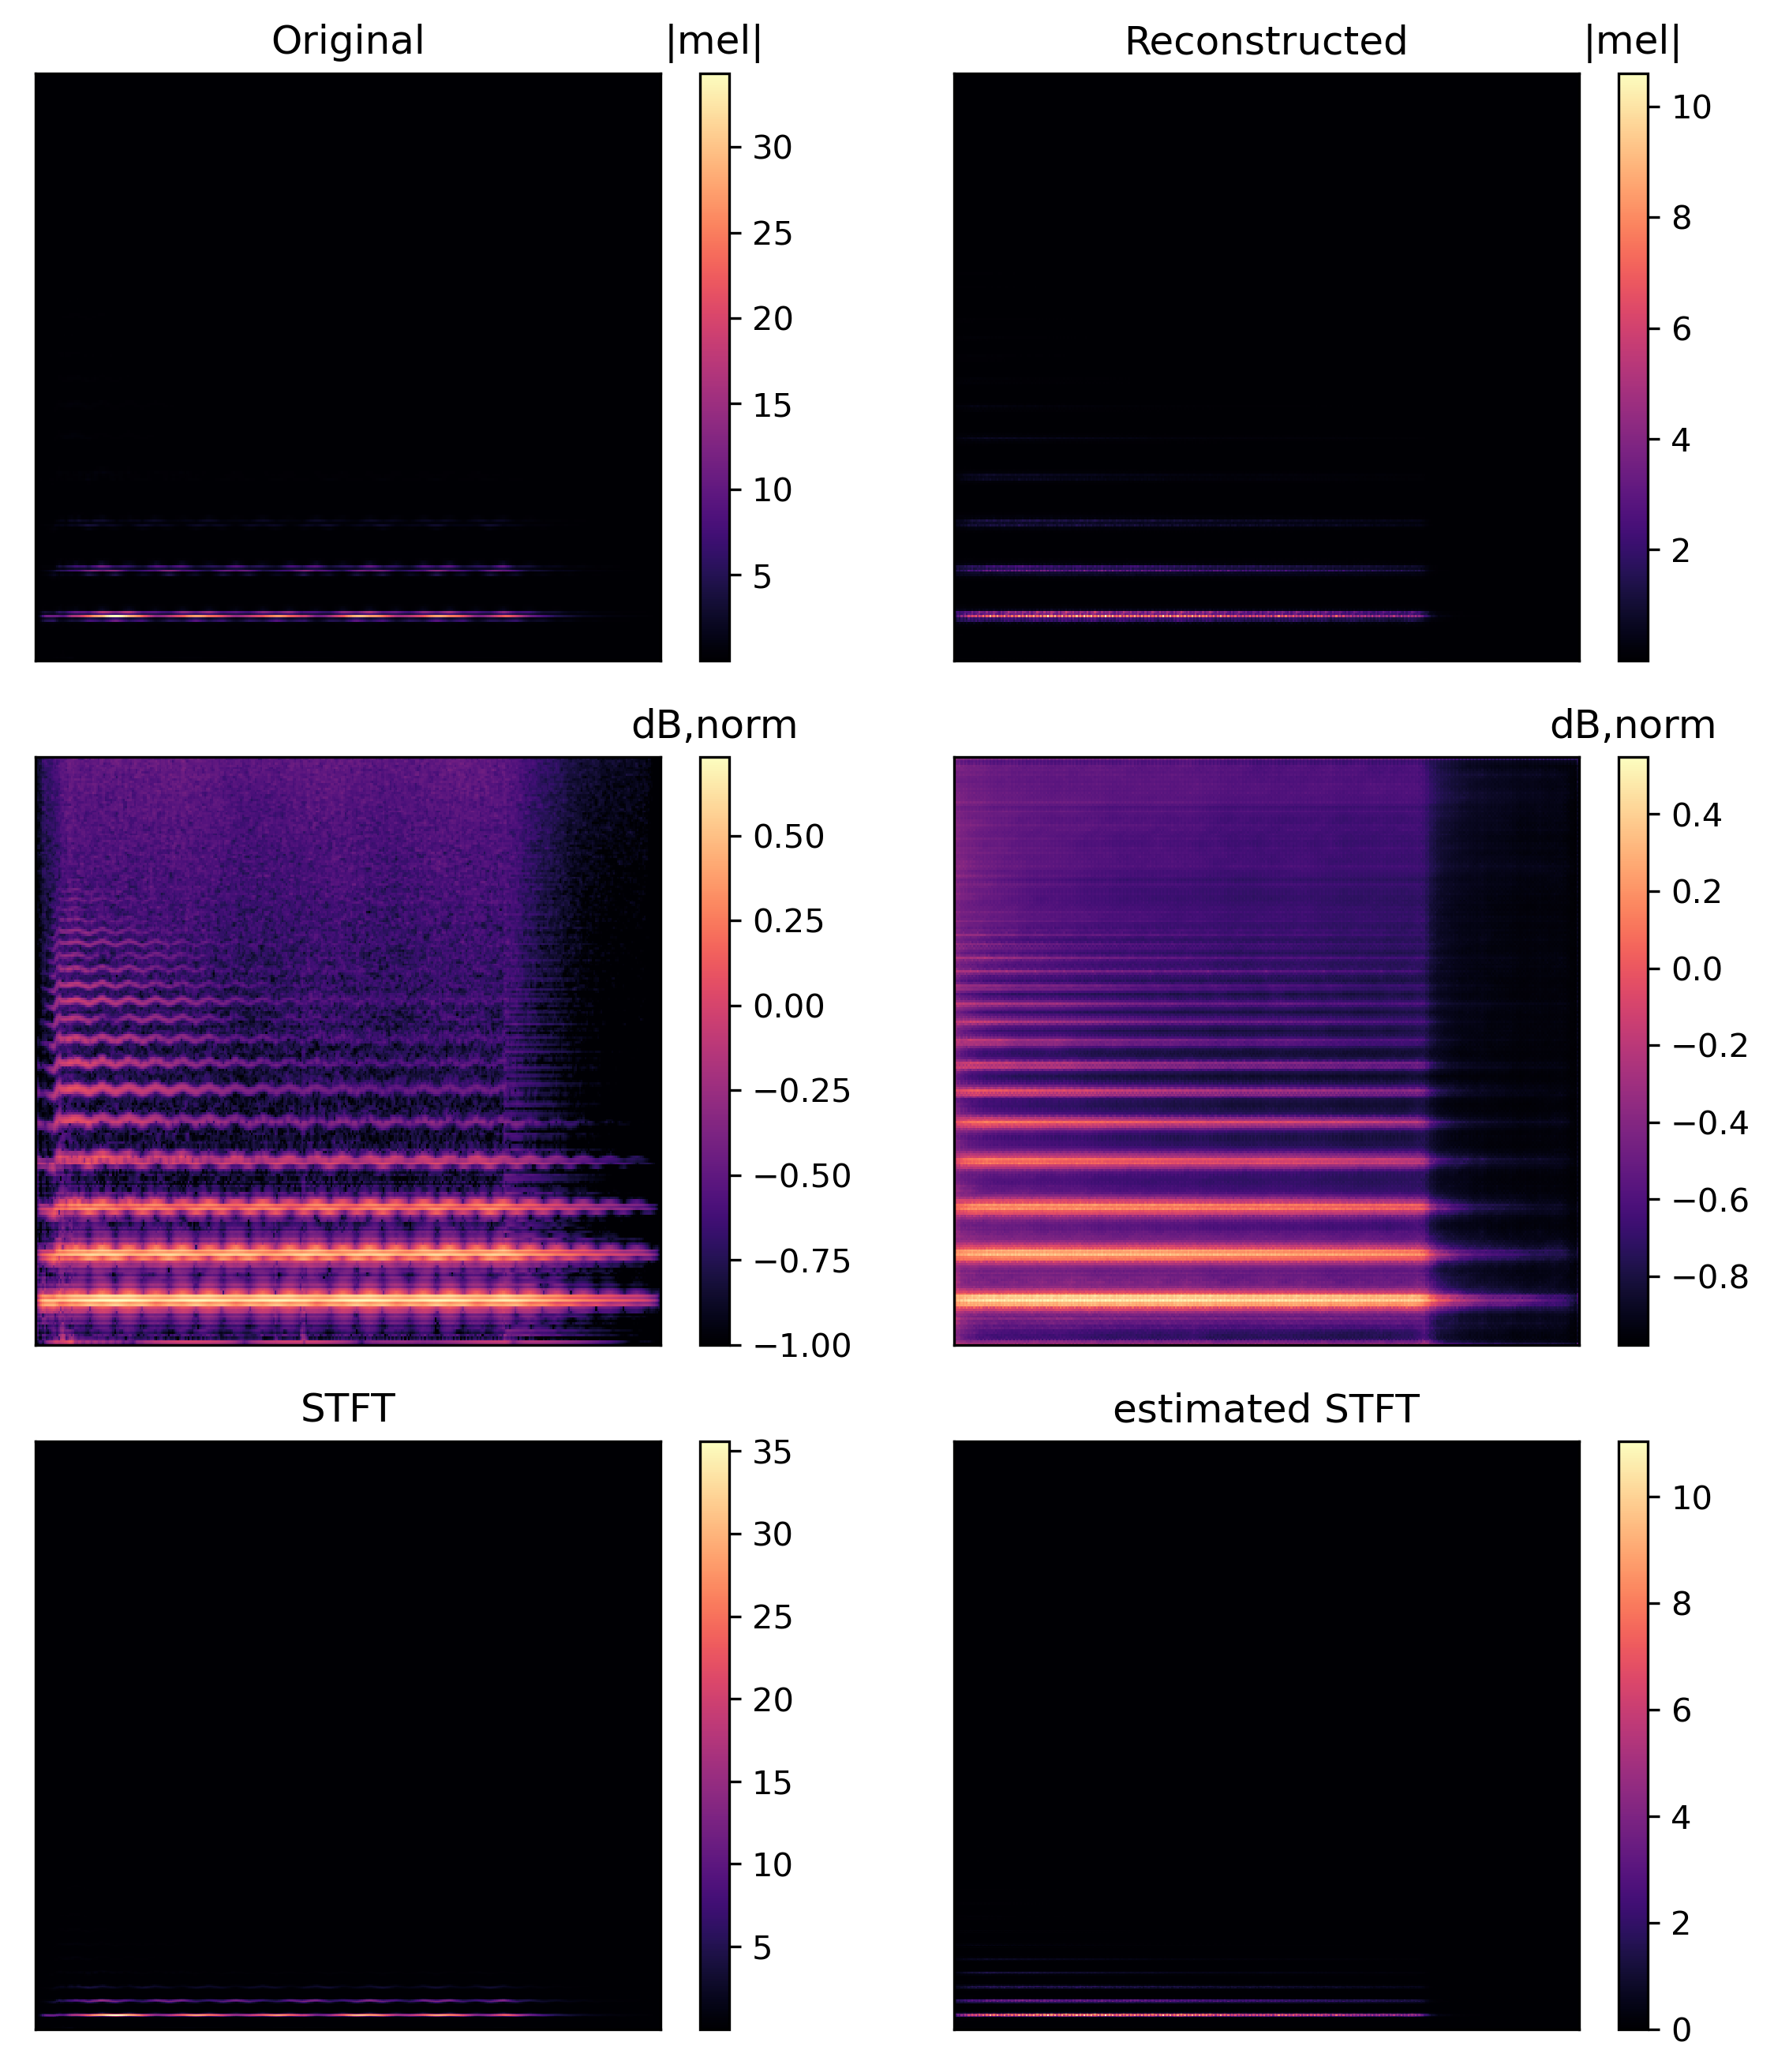

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import librosa.display
import utils.audio
importlib.reload(utils.audio)

cmap = 'magma'

# TODO audio reconstruction - build methods in utils.audio module
dataset_idx = 12
with torch.no_grad():
    x_in, params_in, sample_info = dataset['validation'][dataset_idx]  # single-spectrogram only
    x_out = ae_model(x_in.unsqueeze(0))[2].detach().squeeze(0)  # single-spectrogram only
preset_UID = sample_info[0]

x_wav, Fs = full_dataset._get_wav_file(preset_UID)
if full_dataset.n_mel_bins <= 0:
    original_spec = full_dataset.spectrogram.get_stft(x_wav).numpy()
else:
    original_spec = full_dataset.spectrogram.log_to_linear_scale(full_dataset.denormalize_spectrogram(x_in[0])).numpy()
original_spec_normalized = x_in[0].numpy()
recons_spec_normalized = x_out[0].numpy()
recons_spec_module = full_dataset.denormalize_spectrogram(x_out[0])
recons_spec_module = full_dataset.spectrogram.log_to_linear_scale(recons_spec_module)
if full_dataset.n_mel_bins > 0:
    stft_before_mel = full_dataset.spectrogram.get_stft(x_wav).numpy()
    recons_stft_module = full_dataset.spectrogram.mel_dB_to_STFT(full_dataset.denormalize_spectrogram(x_out[0]))

if full_dataset.n_mel_bins <= 0:
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
else:
    fig, axes = plt.subplots(3, 2, figsize=(8, 9))
im = librosa.display.specshow(np.abs(original_spec), ax=axes[0][0], cmap=cmap)
clb = fig.colorbar(im, ax=axes[0][0], orientation='vertical')
clb.ax.set_title('|stft|' if full_dataset.n_mel_bins <= 0 else '|mel|')
axes[0][0].set(title='Original')
im = librosa.display.specshow(original_spec_normalized, ax=axes[1][0], cmap=cmap)
clb = fig.colorbar(im, ax=axes[1][0], orientation='vertical')
clb.ax.set_title('dB,norm')
im = librosa.display.specshow(recons_spec_normalized, ax=axes[1][1], cmap=cmap)
clb = fig.colorbar(im, ax=axes[1][1], orientation='vertical')
clb.ax.set_title('dB,norm')
im = librosa.display.specshow(recons_spec_module.numpy(), ax=axes[0][1], cmap=cmap)
clb = fig.colorbar(im, ax=axes[0][1], orientation='vertical')
clb.ax.set_title('|stft|' if full_dataset.n_mel_bins <= 0 else '|mel|')
axes[0][1].set(title='Reconstructed')
fig.tight_layout()

# si on a un mel-spectrogramme
if full_dataset.n_mel_bins > 0:
    im = librosa.display.specshow(np.abs(stft_before_mel), ax=axes[2][0], cmap=cmap)
    clb = fig.colorbar(im, ax=axes[2][0], orientation='vertical')
    axes[2][0].set(title="STFT")
    im = librosa.display.specshow(np.abs(recons_stft_module), ax=axes[2][1], cmap=cmap)
    clb = fig.colorbar(im, ax=axes[2][1], orientation='vertical')
    axes[2][1].set(title="estimated STFT")


print("Preset UID={} original audio:".format(preset_UID))
Audio(x_wav, rate=Fs)

In [12]:
# STFT phase of original audio - spectogram is possibly mel-scaled
if full_dataset.n_mel_bins <= 0:
    recons_stft = recons_spec_module.numpy() * np.exp(1j * np.angle(original_spec))
    # G&L and ISTFT
    # FFT size extracted from stft size. Default window: Hann. Phase init: use provided phase
    x_wav_recons = librosa.griffinlim(recons_stft, init=None, hop_length=full_dataset.fft_hop)
else:  # Mel
    recons_stft = recons_stft_module * np.exp(1j * np.angle(stft_before_mel))
    x_wav_recons = librosa.griffinlim(recons_stft, init=None, hop_length=full_dataset.fft_hop)

print("Reconstructed audio (preset UID={})".format(preset_UID))
Audio(x_wav_recons, rate=Fs)

Reconstructed audio (preset UID=7635)


In [13]:
## Latent space entanglement - TODO refaire avec nouveaux metrics latent

import utils.figures
importlib.reload(utils.figures)

latent_plot = utils.figures.LatentPlot()

with torch.no_grad():
    dataloader_iter = iter(dataloader['validation'])
    for i in range(len(dataloader['validation'])):
        x_in, params_in, sample_info = next(dataloader_iter)
        z_mu_logvar, z_sampled, x_out = ae_model(x_in)
        latent_plot.append_latent_values(z_mu_logvar, z_sampled)

fig, ax = latent_plot.plot_distributions_stats()
fig, axes, coeff = latent_plot.plot_spearman_correlation()

AttributeError: module 'utils.figures' has no attribute 'LatentPlot'